# NetCDF handling

NetCDF formatted files are much faster to read and write for large datasets

Both the `ScmDataFrame` and `ScmRun` objects have the ability to read and write netCDF files.

In [1]:
from scmdata.run import ScmRun, df_append
from scmdata.netcdf import nc_to_run
import numpy as np
import xarray as xr
from glob import glob

OUT_FNAME = "/tmp/out_runs.nc"

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
def new_timeseries(
    n=100,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": "World",
            "unit": "K",
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [3]:
# NBVAL_IGNORE_OUTPUT
runs = df_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model scenario                        variable region unit  run_id
	0   example   ssp119             Surface Temperature  World    K       0
	1   example   ssp119  Atmospheric Concentrations|CO2  World    K       0
	2   example   ssp119               Radiative Forcing  World    K       0
	3   example   ssp119             Surface Temperature  World    K       1
	4   example   ssp119  Atmospheric Concentrations|CO2  World    K       1
	5   example   ssp119               Radiative Forcing  World    K       1
	6   example   ssp119             Surface Temperature  World    K       2
	7   example   ssp119  Atmospheric Concentrations|CO2  World    K       2
	8   example   ssp119               Radiative Forcing  World    K       2
	9   example   ssp119             Surface Temperature  World    K       3
	10  example   ssp119  Atmospheric Concentrations|CO2  World    K    

## Reading/Writing to NetCDF4
Writing the runs to disk is easy.

In this case we need to add an additional dimension `run_id` to ensure that each variable and dimension combination has 
unique metadata.

In [4]:
runs.to_nc(OUT_FNAME, dimensions=["run_id"])

The output netCDF file can be read using the `from_nc` method, `nc_to_run` function or directly `xarray`

In [5]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc(OUT_FNAME)

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	    run_id                        variable    model unit region scenario
	30       0  Atmospheric Concentrations|Co2  example    K  World   ssp119
	31       1  Atmospheric Concentrations|Co2  example    K  World   ssp119
	32       2  Atmospheric Concentrations|Co2  example    K  World   ssp119
	33       3  Atmospheric Concentrations|Co2  example    K  World   ssp119
	34       4  Atmospheric Concentrations|Co2  example    K  World   ssp119
	35       5  Atmospheric Concentrations|Co2  example    K  World   ssp119
	36       6  Atmospheric Concentrations|Co2  example    K  World   ssp119
	37       7  Atmospheric Concentrations|Co2  example    K  World   ssp119
	38       8  Atmospheric Concentrations|Co2  example    K  World   ssp119
	39       9  Atmospheric Concentrations|Co2  example    K  World   ssp119
	40       0               Radiative Forcing  example    K  World   ss

In [6]:
# NBVAL_IGNORE_OUTPUT
nc_to_run(ScmRun, OUT_FNAME)

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	    run_id                        variable    model unit region scenario
	60       0  Atmospheric Concentrations|Co2  example    K  World   ssp119
	61       1  Atmospheric Concentrations|Co2  example    K  World   ssp119
	62       2  Atmospheric Concentrations|Co2  example    K  World   ssp119
	63       3  Atmospheric Concentrations|Co2  example    K  World   ssp119
	64       4  Atmospheric Concentrations|Co2  example    K  World   ssp119
	65       5  Atmospheric Concentrations|Co2  example    K  World   ssp119
	66       6  Atmospheric Concentrations|Co2  example    K  World   ssp119
	67       7  Atmospheric Concentrations|Co2  example    K  World   ssp119
	68       8  Atmospheric Concentrations|Co2  example    K  World   ssp119
	69       9  Atmospheric Concentrations|Co2  example    K  World   ssp119
	70       0               Radiative Forcing  example    K  World   ss

In [7]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset(OUT_FNAME)

<xarray.Dataset>
Dimensions:                          (run_id: 10, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * run_id                           (run_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    atmospheric_concentrations__co2  (run_id, time) float64 0.0 0.8258 ... 70.65
    radiative_forcing                (run_id, time) float64 0.0 0.2865 ... 40.11
    surface_temperature              (run_id, time) float64 0.0 0.1607 ... 73.01
Attributes:
    created_at:        2020-04-09T05:29:42.771326
    _scmdata_version:  0.4.0+50.geb2f7fb.dirty

Sometimes if you have complicated ensemble runs it might be more efficient to split the data into smaller subset.

In the below example we iterate over scenarios to produce a netCDF file per scenario

In [8]:
large_run = []

# 10 runs for each scenario
for sce in ["ssp119", "ssp370", "ssp585"]:
    large_run.extend(
        [
            new_timeseries(
                count=3,
                scenario=sce,
                variable=[
                    "Surface Temperature",
                    "Atmospheric Concentrations|CO2",
                    "Radiative Forcing",
                ],
                run_id=run_id,
            )
            for run_id in range(10)
        ]
    )

large_run = df_append(large_run)
# update the run_id to be the auto incrementing key
# Not necessary, but makes for a more realistic example
large_run["run_id"] = large_run.meta.index.values
large_run

<scmdata.ScmRun (timeseries: 90, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	       model scenario                        variable region unit  run_id
	90   example   ssp119             Surface Temperature  World    K      90
	91   example   ssp119  Atmospheric Concentrations|CO2  World    K      91
	92   example   ssp119               Radiative Forcing  World    K      92
	93   example   ssp119             Surface Temperature  World    K      93
	94   example   ssp119  Atmospheric Concentrations|CO2  World    K      94
	..       ...      ...                             ...    ...  ...     ...
	175  example   ssp585  Atmospheric Concentrations|CO2  World    K     175
	176  example   ssp585               Radiative Forcing  World    K     176
	177  example   ssp585             Surface Temperature  World    K     177
	178  example   ssp585  Atmospheric Concentrations|CO2  World    K     178
	179  example   ssp585               Radiative Forcing  Wo

In [9]:
for sce_df in large_run.groupby("scenario"):
    sce = sce_df.get_unique_meta("scenario", True)
    sce_df.to_nc("/tmp/out-{}.nc".format(sce), dimensions=["run_id"])

Data for each scenario can then be loaded independently instead of having to load all the data and then filtering

pyam.plotting - INFO: >=13 labels, not applying legend


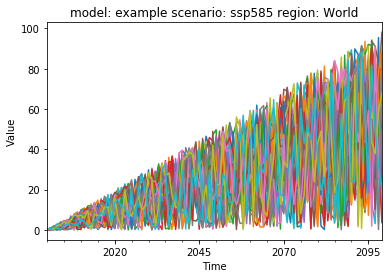

In [10]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc("/tmp/out-ssp585.nc").filter("Surface Temperature").line_plot()

In [11]:
# NBVAL_IGNORE_OUTPUT
# Load all scenarios
df_append([ScmRun.from_nc(fname) for fname in glob("/tmp/out-*.nc")])

<scmdata.ScmRun (timeseries: 90, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	     run_id                        variable    model unit region scenario
	210     151  Atmospheric Concentrations|Co2  example    K  World   ssp585
	211     154  Atmospheric Concentrations|Co2  example    K  World   ssp585
	212     157  Atmospheric Concentrations|Co2  example    K  World   ssp585
	213     160  Atmospheric Concentrations|Co2  example    K  World   ssp585
	214     163  Atmospheric Concentrations|Co2  example    K  World   ssp585
	..      ...                             ...      ...  ...    ...      ...
	295     135             Surface Temperature  example    K  World   ssp370
	296     138             Surface Temperature  example    K  World   ssp370
	297     141             Surface Temperature  example    K  World   ssp370
	298     144             Surface Temperature  example    K  World   ssp370
	299     147             Surface Temperature  example    K